In [45]:
from astropy.io import fits
from astropy.time import Time
import numpy as np
import matplotlib.pyplot as pl
import mpl_defaults as mpld
%matplotlib inline

In [46]:
# source: https://sohowww.nascom.nasa.gov/data/archive.html
blue = fits.open('/Users/tgordon/research/exomoon/blue.fits')
green = fits.open('/Users/tgordon/research/exomoon/green.fits')
red = fits.open('/Users/tgordon/research/exomoon/red.fits')

r, g, b = red[0].data, green[0].data, blue[0].data
mask = np.isfinite(r) & np.isfinite(g) & np.isfinite(b)
start = blue[0].header['DATES'][0:9]
end = blue[0].header['DATES'][14:]
start, end = Time([start, end]).jd
t = np.linspace(start, end, len(r)) - start
r, g, b = r[mask].astype('float64'), g[mask].astype('float64'), b[mask].astype('float64')
t = t[mask]
flux = np.sum([r, g, b], axis=0)/3

In [47]:
i = 160000
di = 1000
t = t[i:i+di]
yerr = np.array([np.exp(-8)*np.ones_like(t) for i in range(3)])
r, g, b, flux = r[i:i+di]/1e3, g[i:i+di]/1e3, b[i:i+di]/1e3, flux[i:i+di]/1e3

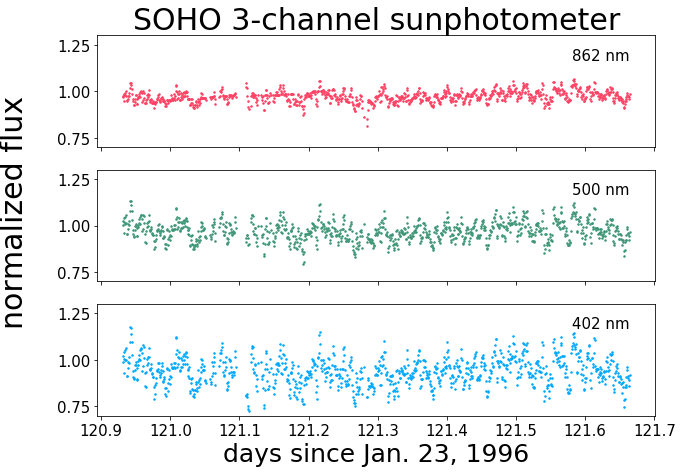

In [48]:
fig, ax = pl.subplots(3, 1, figsize=(10, 7), sharex=True)
ax[0].plot(t, 1+r, '.', color=mpld.red, alpha=1, ms=3.0)
ax[1].plot(t, 1+g, '.', color=mpld.green, alpha=1, ms=3.0)
ax[2].plot(t, 1+b, '.', color=mpld.blue, alpha=1, ms=3.0)
#ax[3].plot(t, 1+flux, '.', color='k', alpha=1, ms=3.0)

ax[0].annotate('862 nm', xy=(0.85, 0.78), xycoords='axes fraction', fontsize=15)
ax[1].annotate('500 nm', xy=(0.85, 0.78), xycoords='axes fraction', fontsize=15)
ax[2].annotate('402 nm', xy=(0.85, 0.78), xycoords='axes fraction', fontsize=15)
ax[0].set_title("SOHO 3-channel sunphotometer")
#ax[3].annotate('total flux', xy=(0.85, 0.78), xycoords='axes fraction', fontsize=15)

[ax.set_ylim(0.7, 1.3) for ax in ax]
ax[2].set_xlabel('days since Jan. 23, 1996')
pl.annotate("normalized flux", xy=(0.0, 0.75), 
            xycoords='figure fraction', 
            rotation=90, fontsize=30)
pl.savefig("/Users/tgordon/Desktop/spm_lc.pdf")

In [70]:
c1 = 1.7
c2 = 2.0
log_S0 = [-8.5, -13, -18]
log_w0 = [2, 6.6, 7.5]
log_Q = [-np.log(np.sqrt(2)), -np.log(np.sqrt(2)), 1]
y = np.vstack((r, g, b)).T.reshape(3*len(t), 1)

import pymc3 as pm
import theano.tensor as tt
import exoplanet as xo
term0 = xo.gp.terms.SHOTerm(
    log_S0 = log_S0[0],
    log_w0 = log_w0[0],
    log_Q=log_Q[0])
term1 = xo.gp.terms.SHOTerm(
    log_S0 = log_S0[1],
    log_w0 = log_w0[1],
    log_Q=log_Q[1])
term2 = xo.gp.terms.SHOTerm(
    log_S0 = log_S0[2],
    log_w0 = log_w0[2],
    log_Q=log_Q[2])
        
q0 = tt.stack([1, c1, c2])
Q0 = q0[:, None]*q0[None, :]
q1 = tt.stack([1, c1, c2])
Q1 = q1[:, None]*q1[None, :]
q2 = tt.stack([1, c1, c2])
Q2 = q2[:, None]*q2[None, :]
        
kernel = (xo.gp.terms.KroneckerTerm(term0, Q0) + 
            xo.gp.terms.KroneckerTerm(term1, Q1) + 
            xo.gp.terms.KroneckerTerm(term2, Q2)
        )

yerr = np.array([np.exp(-8)*np.ones_like(t) for i in range(3)])        
gp = xo.gp.GP(kernel, t, yerr ** 2, J=18)        

In [73]:
n = np.random.randn(3*len(t), 1)
s = gp.dot_l(n).eval()

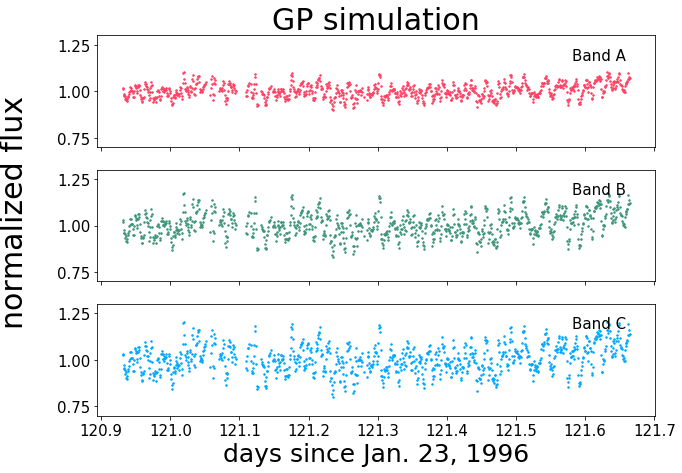

In [74]:
fig, ax = pl.subplots(3, 1, figsize=(10, 7), sharex=True)
ax[0].plot(t, 1+s[::3], '.', color=mpld.red, alpha=1, ms=3.0)
ax[1].plot(t, 1+s[1::3], '.', color=mpld.green, alpha=1, ms=3.0)
ax[2].plot(t, 1+s[2::3], '.', color=mpld.blue, alpha=1, ms=3.0)
#ax[3].plot(t, 1+flux, '.', color='k', alpha=1, ms=3.0)

ax[0].annotate('Band A', xy=(0.85, 0.78), xycoords='axes fraction', fontsize=15)
ax[1].annotate('Band B', xy=(0.85, 0.78), xycoords='axes fraction', fontsize=15)
ax[2].annotate('Band C', xy=(0.85, 0.78), xycoords='axes fraction', fontsize=15)
ax[0].set_title("GP simulation")
#ax[3].annotate('total flux', xy=(0.85, 0.78), xycoords='axes fraction', fontsize=15)

[ax.set_ylim(0.7, 1.3) for ax in ax]
ax[2].set_xlabel('days since Jan. 23, 1996')
pl.annotate("normalized flux", xy=(0.0, 0.75), 
            xycoords='figure fraction', 
            rotation=90, fontsize=30)
pl.savefig("/Users/tgordon/Desktop/gp_lc.pdf")